<a href="https://colab.research.google.com/github/Jenarth/SCS3250-Group-2-Final-Project/blob/master/BY_Outlines_Final_Dataset_(date%2C_line%2C_station%2C_ridership).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Metrolinx Data Analysis

## Import Libraries

In [0]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Read Data Files into DataFrames

### Data File 1: Daily Train Boardings by Hour

* Read Excel file
* Replace NaN with zeros
* Apply a correction factor to handle fractional boardings (due to data alterations at source for confidentiality)
* Convert float columns to integer
* Add daily_total column for sum of hourly columns
* Add year_month and week columns to facilitate data aggregation

#### Read Excel File

[link to Excel file](https://github.com/Jenarth/SCS3250-Group-2-Final-Project/blob/master/GO%20Train%20Boardings_2017-2020.xlsx)

In [102]:
# Load data from Excel file into Pandas DataFrame:
path = 'https://github.com/Jenarth/SCS3250-Group-2-Final-Project/raw/master/GO%20Train%20Boardings_2017-2020.xlsx'

boardings = pd.read_excel(path, 
                          skiprows=1, # skip blank first row
                          usecols=[i for i in range(26)], # no data beyond column 25 (26th column)
                          parse_dates=[1]) # dates in column 1 (2nd column)

# List columns:
boardings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69094 entries, 0 to 69093
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Origin  69094 non-null  object        
 1   Date    69094 non-null  datetime64[ns]
 2   12AM    27381 non-null  float64       
 3   1AM     14521 non-null  float64       
 4   2AM     4294 non-null   float64       
 5   3AM     2535 non-null   float64       
 6   4AM     12866 non-null  float64       
 7   5AM     46922 non-null  float64       
 8   6AM     59113 non-null  float64       
 9   7AM     61954 non-null  float64       
 10  8AM     63100 non-null  float64       
 11  9AM     63702 non-null  float64       
 12  10AM    58368 non-null  float64       
 13  11AM    57093 non-null  float64       
 14  12PM    55188 non-null  float64       
 15  1PM     55418 non-null  float64       
 16  2PM     54763 non-null  float64       
 17  3PM     58323 non-null  float64       
 18  4PM   

In [103]:
# View basic stats:
# !!! Note fractional boarding times!
boardings.describe()

,12AM,1AM,2AM,3AM,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,12PM,1PM,2PM,3PM,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM
count,27381.000000,14521.000000,4294.000000,2535.000000,12866.000000,46922.000000,59113.000000,61954.000000,63100.000000,63702.000000,58368.000000,57093.000000,55188.000000,55418.000000,54763.000000,58323.000000,60503.000000,63552.000000,62650.000000,58958.000000,52024.000000,43032.000000,39708.000000,35913.000000
mean,3.051061,0.786386,0.541258,0.330018,1.483531,9.084917,37.388391,72.269468,38.386135,8.244689,6.734423,6.789881,7.316999,8.059810,10.317160,24.559933,60.281879,56.580424,19.886597,9.377002,6.302798,6.717044,6.739661,5.451131
std,14.819209,3.602854,1.735118,0.972161,3.174297,10.524733,38.587522,78.294051,45.997446,10.511455,9.804487,13.375282,21.866913,29.967103,47.773934,162.297778,465.805895,443.642606,134.127596,55.504257,32.146693,31.748613,34.082614,28.462944
min,-0.270000,-0.405000,-0.270000,0.000000,0.000000,0.000000,0.000000,-1.620000,-49.815000,-12.285000,-2.160000,-0.945000,-0.405000,-0.270000,-1.350000,-0.810000,-0.540000,-0.270000,-8.910000,-0.810000,-0.270000,-0.405000,-0.270000,-0.270000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.215000,6.345000,6.750000,3.780000,0.540000,0.675000,0.540000,0.405000,0.405000,0.405000,0.540000,0.675000,0.675000,0.540000,0.270000,0.000000,0.270000,0.270000,0.000000
50%,0.270000,0.000000,0.000000,0.000000,0.270000,5.265000,23.625000,41.445000,24.300000,4.050000,3.375000,2.835000,2.565000,2.295000,2.565000,2.835000,2.700000,2.295000,1.485000,0.945000,0.810000,1.215000,0.945000,0.540000
75%,0.540000,0.270000,0.405000,0.405000,0.945000,14.445000,55.215000,125.685000,53.325000,12.555000,9.180000,8.370000,7.695000,7.155000,7.020000,8.775000,10.800000,11.070000,6.480000,3.645000,2.970000,2.835000,2.025000,1.080000
max,547.965000,122.850000,58.050000,26.190000,24.300000,72.090000,203.850000,404.460000,367.605000,156.330000,115.560000,268.110000,873.585000,1342.710000,2432.025000,3805.380000,5229.765000,4945.995000,1673.325000,926.505000,436.590000,464.670000,566.865000,679.185000


In [0]:
#########BY
#Q1=boardings.quantile(0.25)
#Q3=boardings.quantile(0.75)
#IQR=Q3-Q1
#print(IQR)
# Call describe on df and transpose it due to the large number of columns
##spread = df.describe().T

# precalculate interquartile range for ease of use in next calculation
##IQR = spread['75%'] - spread['25%']

# create an outliers column which is either 3 IQRs below the first quartile or
# 3 IQRs above the third quartile
##spread['outliers'] = (spread['min']<(spread['25%']-(3*IQR)))|(spread['max'] > (spread['75%']+3*IQR))

# just display the features containing extreme outliers
##spread.ix[spread.outliers,]

In [105]:
# Determine date range:
# !!! Covers all 1096 days (365*3 + leap day) between 2017-03-01 and 2020-02-29.
boardings.Date.describe()

count                   69094
unique                   1096
top       2019-04-02 00:00:00
freq                       68
first     2017-03-01 00:00:00
last      2020-02-29 00:00:00
Name: Date, dtype: object

#### Replace NaN with zeros

In [106]:
# Replace NaNs with zeros:
boardings.fillna(value=0, inplace=True)
boardings.head()

,Origin,Date,12AM,1AM,2AM,3AM,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,12PM,1PM,2PM,3PM,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM
0,Acton GO,2017-03-01,0.0,0.0,0.0,0.0,0.0,0.27,6.885,5.265,0.0,0.27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
1,Acton GO,2017-03-02,0.0,0.0,0.0,0.0,0.0,0.00,6.615,3.645,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.27,0.0,0.0,0.0,0.0,0.0
2,Acton GO,2017-03-03,0.0,0.0,0.0,0.0,0.0,0.27,5.400,4.050,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.27,0.00,0.0,0.0,0.0,0.0,0.0
3,Acton GO,2017-03-04,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
4,Acton GO,2017-03-05,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0


#### Apply a correction factor to handle fractional boardings

In [107]:
# Print out all column names (as input to creating a named list):
boardings.columns

Index(['Origin', 'Date', '12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM',
       '7AM', '8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM',
       '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM'],
      dtype='object')

In [108]:
# Create a named list of just the hourly columns:
time_column_list = ['12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM',
       '7AM', '8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM',
       '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM']

print(len(time_column_list),'columns')

24 columns


In [109]:
# Confirm list has all hourly colums:
boardings[time_column_list].head()

,12AM,1AM,2AM,3AM,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,12PM,1PM,2PM,3PM,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM
0,0.0,0.0,0.0,0.0,0.0,0.27,6.885,5.265,0.0,0.27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.00,6.615,3.645,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.27,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.27,5.400,4.050,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.27,0.00,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0


In [110]:
# Apply corrective factor to shift all values (manipulated at source for confidentiality) to whole numbers:
boardings[time_column_list]=boardings[time_column_list]/.135
boardings.head()

,Origin,Date,12AM,1AM,2AM,3AM,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,12PM,1PM,2PM,3PM,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM
0,Acton GO,2017-03-01,0.0,0.0,0.0,0.0,0.0,2.0,51.0,39.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Acton GO,2017-03-02,0.0,0.0,0.0,0.0,0.0,0.0,49.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
2,Acton GO,2017-03-03,0.0,0.0,0.0,0.0,0.0,2.0,40.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Acton GO,2017-03-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Acton GO,2017-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Convert float columns to integer

In [111]:
# Convert float columns to int (boardings can't be fractional):
boardings[time_column_list] = boardings[time_column_list].astype(int)
boardings.head()

,Origin,Date,12AM,1AM,2AM,3AM,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,12PM,1PM,2PM,3PM,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM
0,Acton GO,2017-03-01,0,0,0,0,0,2,51,39,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Acton GO,2017-03-02,0,0,0,0,0,0,48,26,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
2,Acton GO,2017-03-03,0,0,0,0,0,2,40,29,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0
3,Acton GO,2017-03-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Acton GO,2017-03-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


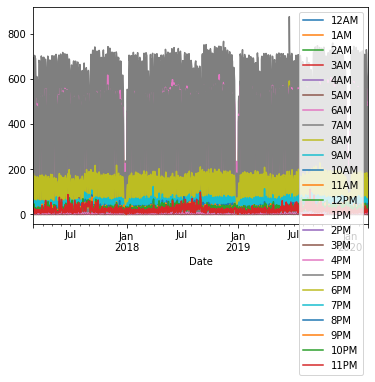

In [112]:
boardings.groupby(['Date']).mean().plot()

#### Add daily_total column for sum of hourly columns

In [113]:
#Add new column for daily totals:
boardings['daily_total'] = boardings[time_column_list].agg('sum', axis='columns')
boardings.head()

,Origin,Date,12AM,1AM,2AM,3AM,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,12PM,1PM,2PM,3PM,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM,daily_total
0,Acton GO,2017-03-01,0,0,0,0,0,2,51,39,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,94
1,Acton GO,2017-03-02,0,0,0,0,0,0,48,26,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,76
2,Acton GO,2017-03-03,0,0,0,0,0,2,40,29,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,73
3,Acton GO,2017-03-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Acton GO,2017-03-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


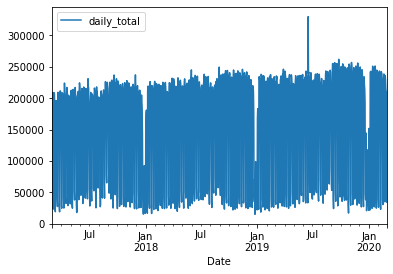

In [114]:
boardings[['Date', 'daily_total']].groupby(by='Date').sum().plot()

In [115]:
boardings.head()

,Origin,Date,12AM,1AM,2AM,3AM,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,12PM,1PM,2PM,3PM,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM,daily_total
0,Acton GO,2017-03-01,0,0,0,0,0,2,51,39,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,94
1,Acton GO,2017-03-02,0,0,0,0,0,0,48,26,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,76
2,Acton GO,2017-03-03,0,0,0,0,0,2,40,29,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,73
3,Acton GO,2017-03-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Acton GO,2017-03-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Create an aggregated daily_boardings DataFrame

In [116]:
daily_boardings = boardings[['Origin', 'Date', 'daily_total']]
daily_boardings

,Origin,Date,daily_total
0,Acton GO,2017-03-01,94
1,Acton GO,2017-03-02,76
2,Acton GO,2017-03-03,73
3,Acton GO,2017-03-04,0
4,Acton GO,2017-03-05,0
...,...,...,...
69089,York University GO,2020-02-24,275
69090,York University GO,2020-02-25,287
69091,York University GO,2020-02-26,269
69092,York University GO,2020-02-27,264


### Data File 2: Access Points (Bus Stop and Train Station Details)

In [119]:
path = 'https://raw.githubusercontent.com/Jenarth/SCS3250-Group-2-Final-Project/master/GO%20Access%20Points.csv'
access_points = pd.read_csv(path, sep=',')
access_points

,station name,Station Name Trimmed,Clean Stop Name,Line ID,Line Name,Station ID,stop_lat,stop_lon,rail_distance_from_union_miles,Subway,University_College,University_Nm,GO Station_Line,Park and Ride_Carpool,Terminal Station,Shopping Centre,Parent Station,City
0,1| 55|Union Station Rail,Union Station Rail,Union Station,0,Union Station,0,43.645195,-79.380600,0.00,0.0,0.0,NaN,0.0,0.0,0.0,0.0,Union Station Rail,Toronto
1,1| 1|Agincourt GO Station Rail,Agincourt GO Station Rail,Agincourt GO,6,Stouffville,6002,43.786110,-79.284385,14.10,0.0,0.0,NaN,6.0,0.0,0.0,0.0,Agincourt GO Station Rail,Scarborough
2,1| 2|Ajax GO Station Rail,Ajax GO Station Rail,Ajax GO,7,Lakeshore East,7007,43.847766,-79.041372,23.43,0.0,0.0,NaN,7.0,0.0,0.0,0.0,Ajax GO Station Rail,Ajax
3,1| 3|Aldershot GO Station Rail,Aldershot GO Station Rail,Aldershot GO,1,Lakeshore West,1010,43.313385,-79.855659,34.60,0.0,0.0,NaN,1.0,0.0,0.0,0.0,Aldershot GO Station Rail,Burlington
4,1| 4|Appleby GO Station Rail,Appleby GO Station Rail,Appleby GO,1,Lakeshore West,1008,43.379429,-79.760991,27.90,0.0,0.0,NaN,1.0,0.0,0.0,0.0,Appleby GO Station Rail,Burlington
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,1| 2954|Brampton - BramaleaGOStation At Steeles,Brampton - BramaleaGOStation At Steeles,Bramalea GO Bus,8,GO Bus,80454,43.702150,-79.689512,NaN,0.0,0.0,NaN,3.0,1.0,0.0,0.0,Bramalea GO Station Rail,Bramalea
973,1| 922|Toronto - McCowanRd At ProgressAve,Toronto - McCowanRd At ProgressAve,Toronto - McCowanRd At ProgressAve,8,GO Bus,80899,NaN,NaN,NaN,0.0,0.0,NaN,-1.0,0.0,0.0,0.0,NaN,Toronto
974,1| 2884|Oshawa- Simcoe St At Britannia Ave,Oshawa- Simcoe St At Britannia Ave,Oshawa- Simcoe St At Britannia Ave,8,GO Bus,80900,NaN,NaN,NaN,0.0,0.0,NaN,-1.0,0.0,0.0,0.0,NaN,Oshawa
975,1| 2885|Oshawa- Simcoe St At Britannia Ave,Oshawa- Simcoe St At Britannia Ave,Oshawa- Simcoe St At Britannia Ave,8,GO Bus,80901,NaN,NaN,NaN,0.0,0.0,NaN,-1.0,0.0,0.0,0.0,NaN,Oshawa


#### Select Required Rows and Columns from Access Points Data to Create 'go_stations' DataFrame

* Filter access points for GO Train stations (exclude GO Bus stops).
* Select required columns: 
 * Clean Stop Name
 * Line ID
 * Line Name

Create a new go_stations dataframe with only required columns and only GO Train stations. (Remove bus stops.)

In [120]:
go_stations = access_points.loc[
                                (access_points['Clean Stop Name'].str.endswith('GO')) |
                                (access_points['Clean Stop Name']=='Union Station') |
                                (access_points['Clean Stop Name']=='Hamilton GO Centre'),
                                'Clean Stop Name':'Line Name'
                                ]
go_stations

,Clean Stop Name,Line ID,Line Name
0,Union Station,0,Union Station
1,Agincourt GO,6,Stouffville
2,Ajax GO,7,Lakeshore East
3,Aldershot GO,1,Lakeshore West
4,Appleby GO,1,Lakeshore West
...,...,...,...
63,Acton GO,3,Kitchener
64,Allandale Waterfront GO,4,Barrie
65,West Harbour GO,1,Lakeshore West
66,Gormley GO,5,Richmond Hill


## Merge go_stations into daily_boardings DataFrame

* Left join daily_boardings['Origin'] = go_stations['Clean Stop Name']
 * Check merge.
* Drop 'Clean Stop Name' column.
* Rename columns.
* Change column order.
* Set Date as the DataFrame index.

### Merge

In [121]:
daily_boardings = pd.merge(daily_boardings, go_stations, left_on='Origin', right_on='Clean Stop Name', how='left')
daily_boardings

,Origin,Date,daily_total,Clean Stop Name,Line ID,Line Name
0,Acton GO,2017-03-01,94,Acton GO,3,Kitchener
1,Acton GO,2017-03-02,76,Acton GO,3,Kitchener
2,Acton GO,2017-03-03,73,Acton GO,3,Kitchener
3,Acton GO,2017-03-04,0,Acton GO,3,Kitchener
4,Acton GO,2017-03-05,0,Acton GO,3,Kitchener
...,...,...,...,...,...,...
69089,York University GO,2020-02-24,275,York University GO,4,Barrie
69090,York University GO,2020-02-25,287,York University GO,4,Barrie
69091,York University GO,2020-02-26,269,York University GO,4,Barrie
69092,York University GO,2020-02-27,264,York University GO,4,Barrie


#### Check Merge - Should Be No Nulls in Line ID

In [122]:
daily_boardings[daily_boardings['Line ID'].isnull()]

,Origin,Date,daily_total,Clean Stop Name,Line ID,Line Name


### Drop 'Clean Stop Name' column.

In [123]:
daily_boardings.drop(columns='Clean Stop Name', inplace=True)
daily_boardings

,Origin,Date,daily_total,Line ID,Line Name
0,Acton GO,2017-03-01,94,3,Kitchener
1,Acton GO,2017-03-02,76,3,Kitchener
2,Acton GO,2017-03-03,73,3,Kitchener
3,Acton GO,2017-03-04,0,3,Kitchener
4,Acton GO,2017-03-05,0,3,Kitchener
...,...,...,...,...,...
69089,York University GO,2020-02-24,275,4,Barrie
69090,York University GO,2020-02-25,287,4,Barrie
69091,York University GO,2020-02-26,269,4,Barrie
69092,York University GO,2020-02-27,264,4,Barrie


### Rename Columns

In [124]:
daily_boardings.rename(columns={'Origin':'station_name', 'Line Name':'line_name', 'Line ID':'line_id'}, inplace=True)
daily_boardings

,station_name,Date,daily_total,line_id,line_name
0,Acton GO,2017-03-01,94,3,Kitchener
1,Acton GO,2017-03-02,76,3,Kitchener
2,Acton GO,2017-03-03,73,3,Kitchener
3,Acton GO,2017-03-04,0,3,Kitchener
4,Acton GO,2017-03-05,0,3,Kitchener
...,...,...,...,...,...
69089,York University GO,2020-02-24,275,4,Barrie
69090,York University GO,2020-02-25,287,4,Barrie
69091,York University GO,2020-02-26,269,4,Barrie
69092,York University GO,2020-02-27,264,4,Barrie


In [143]:
####BY
##BY
Q1=boardings.quantile(0.25)
Q3=boardings.quantile(0.75)
IQR=Q3-Q1
print(IQR)

##Detect Outliners(The data point where we have False that means 
#these values are valid whereas True indicates presence of an outlier.)

outliers= (daily_boardings < (Q1 - 1.5 * IQR)) |(daily_boardings > (Q3 + 1.5 * IQR))
print(outliers)

###BY
#Remove Outliers
outliers = daily_boardings[~((daily_boardings < (Q1 - 1.5 * IQR)) |(daily_boardings> (Q3 + 1.5 * IQR))).any(axis=1)]
outliers.shape


12AM              0.00
1AM               0.00
2AM               0.00
3AM               0.00
4AM               0.00
5AM              61.00
6AM             342.00
7AM             847.75
8AM             360.00
9AM              83.00
10AM             55.00
11AM             52.00
12PM             46.00
1PM              43.00
2PM              42.00
3PM              53.00
4PM              66.00
5PM              71.00
6PM              40.00
7PM              22.00
8PM              16.00
9PM              13.00
10PM              9.00
11PM              4.00
daily_total    2071.00
dtype: float64
             10AM   10PM   11AM  ...  line_id  line_name  station_name
Date                             ...                                  
2017-03-01  False  False  False  ...    False      False         False
2017-03-02  False  False  False  ...    False      False         False
2017-03-03  False  False  False  ...    False      False         False
2017-03-04  False  False  False  ...    False      Fals

(66110, 4)

In [139]:
daily_boardings.line_id.value_counts()

1    13989
3    11633
4    11534
7     9863
6     9117
2     7897
5     3965
0     1096
Name: line_id, dtype: int64

### Change Column Order

In [140]:
daily_boardings = daily_boardings[['Date', 'line_id', 'line_name', 'station_name', 'daily_total']]
daily_boardings

KeyError: ignored

### Set Date as Index

In [127]:
daily_boardings.set_index('Date', inplace=True)
daily_boardings.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69094 entries, 2017-03-01 to 2020-02-28
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   line_id       69094 non-null  int64 
 1   line_name     69094 non-null  object
 2   station_name  69094 non-null  object
 3   daily_total   69094 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.6+ MB


In [128]:
daily_boardings.head()

,line_id,line_name,station_name,daily_total
Date,,,,
2017-03-01,3,Kitchener,Acton GO,94
2017-03-02,3,Kitchener,Acton GO,76
2017-03-03,3,Kitchener,Acton GO,73
2017-03-04,3,Kitchener,Acton GO,0
2017-03-05,3,Kitchener,Acton GO,0


In [135]:
#BY
# Call describe on df and transpose it due to the large number of columns
##spread = daily_boardings.describe().T

# precalculate interquartile range for ease of use in next calculation
##IQR = spread['75%'] - spread['25%']

# create an outliers column which is either 3 IQRs below the first quartile or
# 3 IQRs above the third quartile
##spread['outliers'] = (spread['min']<(spread['25%']-(3*IQR)))|(spread['max'] > (spread['75%']+3*IQR))


# just display the features containing extreme outliers
##spread[spread.outliers]


####BY
##BY
Q1=boardings.quantile(0.25)
Q3=boardings.quantile(0.75)
IQR=Q3-Q1
print(IQR)

##Detect Outliners(The data point where we have False that means 
#these values are valid whereas True indicates presence of an outlier.)

outliers= (daily_boardings < (Q1 - 1.5 * IQR)) |(daily_boardings > (Q3 + 1.5 * IQR))
print(outliers)

###BY
#Remove Outliers
daily_boardings_out = daily_boardings[~((daily_boardings < (Q1 - 1.5 * IQR)) |(daily_boardings> (Q3 + 1.5 * IQR))).any(axis=1)]
daily_boardings_out.shape


12AM              0.00
1AM               0.00
2AM               0.00
3AM               0.00
4AM               0.00
5AM              61.00
6AM             342.00
7AM             847.75
8AM             360.00
9AM              83.00
10AM             55.00
11AM             52.00
12PM             46.00
1PM              43.00
2PM              42.00
3PM              53.00
4PM              66.00
5PM              71.00
6PM              40.00
7PM              22.00
8PM              16.00
9PM              13.00
10PM              9.00
11PM              4.00
daily_total    2071.00
dtype: float64
             10AM   10PM   11AM  ...  line_id  line_name  station_name
Date                             ...                                  
2017-03-01  False  False  False  ...    False      False         False
2017-03-02  False  False  False  ...    False      False         False
2017-03-03  False  False  False  ...    False      False         False
2017-03-04  False  False  False  ...    False      Fals

(66110, 4)

## Sample Visualisations (See Lakeshore West)

line_name
Barrie               AxesSubplot(0.125,0.2;0.775x0.68)
Kitchener            AxesSubplot(0.125,0.2;0.775x0.68)
Lakeshore East       AxesSubplot(0.125,0.2;0.775x0.68)
Lakeshore West       AxesSubplot(0.125,0.2;0.775x0.68)
Milton               AxesSubplot(0.125,0.2;0.775x0.68)
Richmond Hill        AxesSubplot(0.125,0.2;0.775x0.68)
Stouffville          AxesSubplot(0.125,0.2;0.775x0.68)
Union Station     AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

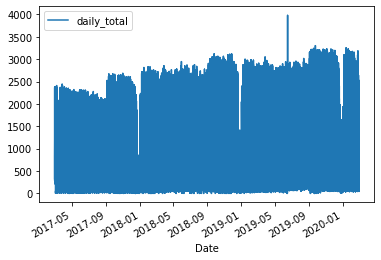

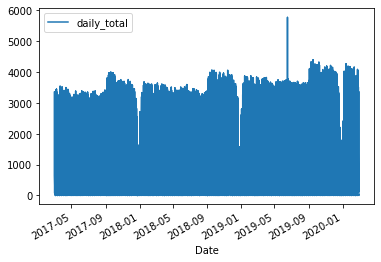

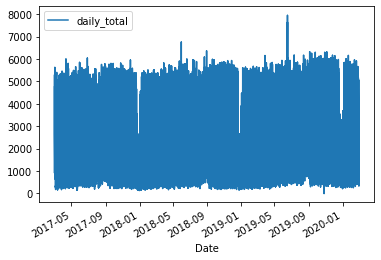

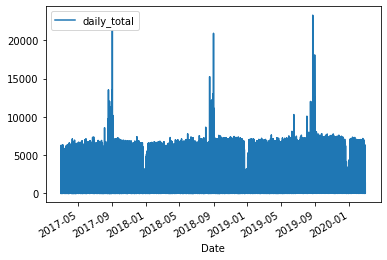

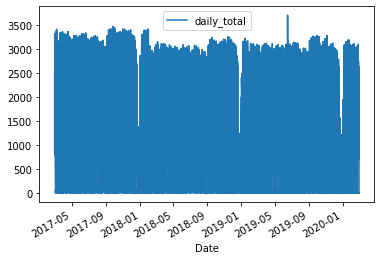

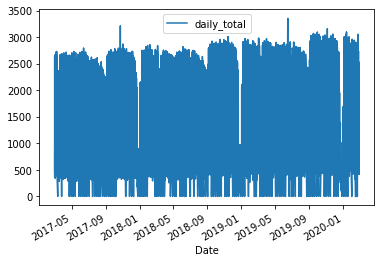

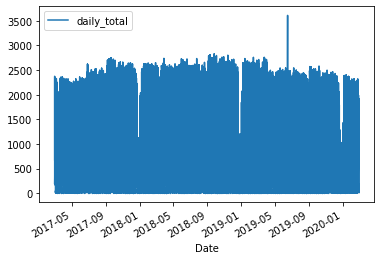

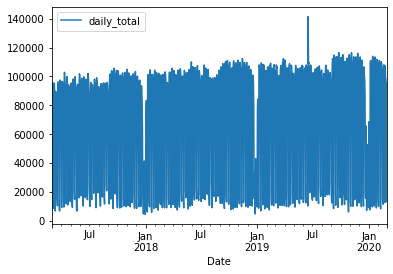

In [137]:
daily_boardings[['line_name', 'daily_total']].groupby(by='line_name').plot()

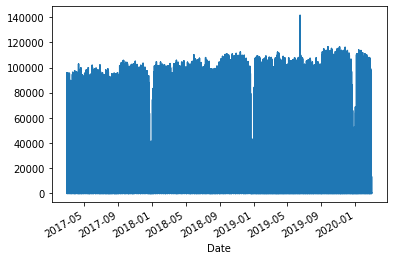

In [131]:
daily_boardings.daily_total.plot()

In [0]:
daily_boardings.to_csv("Final GO Dataset.csv")